# Weekly Tutorial Problems: Week 1
Jérôme Dockès, Nikhil Bhagwat, Jacob Sanz-Robinson.

Welcome to the first set of tutorial problems of the ABCD ReproNim Machine Learning course! They are largely based on Jérôme and Nikhil's exercises for the MAIN educational course: https://github.com/neurodatascience/main-2021-ml-parts-1-2

Let's get started.

# Lecture 1: Core Concepts in Machine Learning 1

## Question 1: Fitting and Prediction

We have a chunk of code below. It imports the necessary libraries, generates some random data, and creates an instance of a linear least squares model with l2 (ridge) regularization. It fits the model to the data, obtains predictions, and calculates the Mean Squared Error of the predictions that were made.

**Your task:**
* The code runs, but there is a methodological issue in the way we are fitting data. What is this issue in the code below?

In [2]:
import numpy as np
from sklearn.datasets import make_regression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

X, y = make_regression(n_samples=80, n_features=600, noise=10, random_state=0) #Generates a random linear combination of random features, with noise.

model = Ridge(alpha=1e-8)
model.fit(X, y)
predictions = model.predict(X)
mse = mean_squared_error(y, predictions)

print(f"\nMean Squared Error: {mse}")
print("MSE is 0 up to machine precision:", np.allclose(mse, 0))


Mean Squared Error: 4.517296683845795e-18
MSE is 0 up to machine precision: True


Now let's compare training and testing performance. We generate some new data, and split it into a train and test set.

**Your task:**
* Fit the model on training data only, get predictions for test data, and compute prediction error. Is it a much larger than error on the training data?

In [9]:
X, y = make_regression(n_samples=160, n_features=600, noise=10, random_state=0)
X_train, X_test = X[:80], X[80:]
y_train, y_test = y[:80], y[80:]

#Your code here

model = Ridge(alpha=1e-8) # alpha was too small
model.fit(X_train, y_train)
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)

print(f"\nMean Squared Error: {mse}")
print("MSE is 0 up to machine precision:", np.allclose(mse, 0))



Mean Squared Error: 25420.842988621494
MSE is 0 up to machine precision: False


## Question 2: Cross-Validation

As in the previous question, we import the libraries we need, generate some random data, and create an instance of a linear least squares model with l2 regularization.

In [15]:
from sklearn.datasets import make_regression
from sklearn import model_selection
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV

X, y = make_regression(noise=10) #Generates a random linear combination of random features, with noise.


**Your task (should be ~2 lines of code):**
* Using an appropriate function from scikit-learn, compute cross-validation scores for a ridge regression on this dataset.
* What cross-validation strategy are you using? What do the scores represent -- what performance metric is used?
* What is a good choice for k?
* Once you are satisfied with the scores, fit the model to the data.

In [20]:
model = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1], cv=10)
model.fit(X, y)
predictions = model.predict(X)
mse = mean_squared_error(y, predictions)
print(mse)

0.07685940254152152


## Question 3: Hyperparameters and Grid Search

The chunk of code below imports the necessary datasets, generates some random data for us to classify.

**Your task:**
* Modify the "model" variable. It should use the GridSearchCV to run a Logistic Regression, doing a grid search over at least 3 different values of C (I suggest they each vary by an order of magnitude), and "l1" and "l2" penalty types.

In [31]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, GridSearchCV
from matplotlib import pyplot as plt

X, y = make_classification() #Generate random data
parameters = {'C':[0.001, 0.1,1, 10, 100], 'penalty': ['l1', 'l2']}
model = GridSearchCV(LogisticRegression(solver='liblinear'), parameters)#Your line of code goes here!
scores = cross_validate(model, X, y)
print(scores)

{'fit_time': array([0.10168505, 0.0901289 , 0.07944107, 0.14998007, 0.28583193]), 'score_time': array([0.00025582, 0.00020623, 0.00042486, 0.00053692, 0.00043106]), 'test_score': array([0.9 , 0.85, 0.8 , 0.95, 0.85])}


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


## Question 4: Prediction and Performance Scores

In this question we're going to build a model that can recognize handwritten digits.

Firstly, below are all the libraries we are going to use for this question. I suggest you Google them, or have a glance at their documentation if you don't already recognize them! Popular libraries often have very informative documentation, complete with examples.
For example: https://scikit-learn.org/stable/user_guide.html

In [59]:
from sklearn.datasets import fetch_openml
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
import ssl

We're going to download the dataset we'll be using. It's the MNIST dataset - a set of 70,000 images of digits handwritten by high school students. It's a commonly used benchmark for Machine Learning algorithms, and a part of many Machine Learning courses, earning it it's infamous nickname of the 'Hello World' of Machine Learning.

In [60]:
mnist = fetch_openml('mnist_784', version=1, as_frame= False) #~130MB, might take a little time to download!
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

Let's look at the data dimensions, what the first digit looks like, and what it's label is:

(70000, 784)


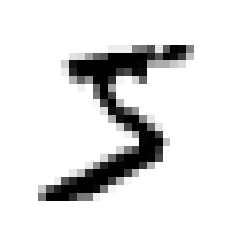

5


In [61]:
X, y = mnist["data"], mnist["target"]
print(X.shape) 

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

print(y[0])

Now we're going to separate the data to use the first 60,000 images as our training set, and the final 10,000 for our test set.

We're going to try to quickly make a binary classification model. It will be able to tell the difference between the number 5 and all the other digits. A 5-detector.

Our classifier will be an instance of a SGDClassifier model. I've chosen this classifier because it can handle large datasets efficiently. The default setting we are using is a linear SVM (you will see what this is next week). It is sped up by using a variation of Gradient Descent - Stochastic Gradient Descent (deals with training instances independently, one at a time).

In [62]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
y_train = y_train.astype(np.int8) #Casting labels from strings to integers

#Here we are binarizing our labels. All labels that are 5 are converted to True, and the rest to False. 
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

sgd_clf = SGDClassifier(random_state=42) #42 is arbitrarily chosen. From documentation: "Pass an int for reproducible output across multiple function calls"

**Your task (should only be ~3 lines of code):**
* Fit the sgd_clf model to the training data, and make a prediction using it. Was the prediction it made right?
* Run cross validation using 3 folds on the model to determine it's accuracy. What accuracies are you getting for the 3 folds?

In [156]:
from random import seed
from random import randint
#sgd_clf.fit(X_train, y_train_5)
seed(1)
random_digit = randint(0, 783)
random_digit
sgd_clf.predict([X_train[random_digit]])
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

If you did everything right, you probably got something amazing, like 95% accuracy on all folds.
Too good to be true? Yup...only about 10% of the images are 5s, so if you always guess that an image is NOT a 5, you will be right about 90% of the time...Not as impressive now.

**Your task (should only be ~2 lines of code):**

Use the appropriate imported libraries to:
* Obtain the predictions made on each fold of the training data.
* Build a confusion matrix for these predictions.

In [177]:
y_train_predictions = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
confusion_matrix(y_train_5, y_train_predictions)

y_test_predictions = sgd_clf.predict(X_test)
y_test_predictions
confusion_matrix(y_test_5, y_test_predictions)

array([False, False, False, ..., False,  True, False])

Remember that each row in a confusion matrix represents an actual class, while each column represents a predicted class. So the first row of this matrix considers non-5 images (the negative class). The second row considers the images of 5s (the positive class).

**Your task:**
In your confusion Matrix, how many did you get for each of
* true negatives: 
* false positives: 
* false negatives: 
* true positives:

* Use sklearn to find the precision, recall, and f1_score of these obtained predictions.

In [182]:
prec_score = precision_score(y_train_5, y_train_predictions)
rec_score = recall_score(y_train_5, y_train_predictions)
f1 = f1_score(y_train_5, y_train_predictions)
print(prec_score)
print(rec_score)
print(f1)

0.8370879772350012
0.6511713705958311
0.7325171197343846


# Lecture 2: Core Concepts in Machine Learning 2

## Question 1: Dataset Transformation
**Your task:**
Use an sklearn function seen in the recorded lectures to modify the variable X_scaled. X_scaled should standardize the feature variable X by removing the mean and scaling to unit variance.

In [186]:
import numpy as np
from sklearn.preprocessing import StandardScaler

X = np.asarray([[0, 1, -10], [0, -1, 0], [1, 0, 10], [1, 0, 0]])
print(f"X:\n{X}\n")

X_scaled = StandardScaler().fit_transform(X)

print(f"X scaled:\n{X_scaled}\n")
print(f"mean: {X_scaled.mean(axis=0)}\nstd: {X_scaled.std(axis=0)}")

X:
[[  0   1 -10]
 [  0  -1   0]
 [  1   0  10]
 [  1   0   0]]

X scaled:
[[-1.          1.41421356 -1.41421356]
 [-1.         -1.41421356  0.        ]
 [ 1.          0.          1.41421356]
 [ 1.          0.          0.        ]]

mean: [0. 0. 0.]
std: [1. 1. 1.]


## Question 2: Feature Selection

As in the previous questions, we import relevant libraries and generate random data for regression. We then use the SelectKBest function from sklearn to perform feature selection (select features according to the k highest scores using f_regression - a linear model for testing the effect of a regressor), and perform cross validation using the Ridge linear model.

**Your task:**
What is the methodological issue with the chunk of code?

In [191]:
from sklearn.datasets import make_regression
from sklearn.linear_model import Ridge
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline
from matplotlib import pyplot as plt

X, y = make_regression(noise=10, n_features=5000, random_state=0)

X_reduced = SelectKBest(f_regression).fit_transform(X, y)
scores = cross_validate(Ridge(), X_reduced, y)["test_score"]
print("feature selection in 'preprocessing':", scores)

feature selection in 'preprocessing': [0.81169757 0.63046326 0.54143034 0.72676923 0.8752332 ]


array([[-4.86285398e-01, -1.01741511e+00,  2.39093389e+00,
         6.56074855e-01, -5.14291638e-03, -1.07065313e+00,
        -8.34071834e-01,  4.90508705e-01, -1.04731258e+00,
         4.04362488e-01],
       [-4.88616707e-01,  1.74417642e-01,  1.48794215e+00,
        -1.45400699e+00, -7.91312462e-01, -7.03575346e-01,
        -3.96352131e-01,  7.83364389e-01, -4.43388255e-01,
         8.40540542e-01],
       [ 1.86503252e+00,  1.12647246e-01, -1.80392424e+00,
         9.77140876e-01,  8.55592136e-01, -1.58456063e-01,
        -8.67622315e-01,  3.41727905e-02, -1.03868680e+00,
        -5.95789758e-01],
       [ 2.33170994e+00,  1.43147168e+00, -1.77810394e-01,
         2.28108813e-01, -5.35201799e-01, -1.27888939e+00,
         8.78956167e-01, -4.37168902e-01,  9.72262333e-01,
        -1.08502512e+00],
       [ 1.21814973e+00, -2.60357693e+00, -1.66014970e-01,
         1.75086156e+00,  9.61774654e-01,  4.17851641e-01,
         1.16062249e+00, -8.99499419e-01, -7.65064901e-01,
         2.

So...now let's fix it. To do this we are going to create a pipeline. We will make sure to fit the whole pipeline to the training set.

**Your task:**
* Modify the 'model' variable. Use the appropriate sklearn method to make a pipeline out of the functions from the previous chunk of code.
* How do your results vary? Why do you think this is?

feature selection on train set: [ 0.11577751  0.0439333  -0.27625968  0.32327364  0.28367254]


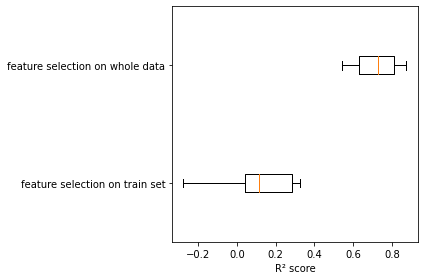

In [192]:
model = make_pipeline(SelectKBest(f_regression), Ridge())
scores_pipe = cross_validate(model, X, y)["test_score"]
print("feature selection on train set:", scores_pipe)


# Plotting our results!
plt.boxplot(
    [scores_pipe, scores],
    vert=False,
    labels=[
        "feature selection on train set",
        "feature selection on whole data",
    ],
)
plt.gca().set_xlabel("R² score")
plt.tight_layout()
plt.show()

## Question 3: Dimensionality Reduction

The sklearn library has included a dataset featuring breast cancer data. We fit the data, then transform it, standardizing the feature variable.

**Your task:**
* Use the sklearn PCA model to only keep the first two principal components of the data.
* Fit the PCA model to breast cancer data, and tranform the data onto the first two principal components.
* Compare original and reduced shape of the data...Is it behaving how you would expect?
* Bonus: Create a plot to visualize the first vs second principal components (or any other method you would like to compare them)! Does it seem like the classes are easily separable?

In [208]:
from sklearn.datasets import load_breast_cancer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

cancer = load_breast_cancer()
scaler = StandardScaler()
scaler.fit(cancer.data)
X_scaled = scaler.transform(cancer.data)

#cancer
pca = PCA(n_components=2)
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)
print(str(X_scaled.shape))
print(str(X_pca.shape))

(569, 30)
(569, 2)


## Question 4: Big Picture - Scanning site prediction

We have some fMRI time series, that we use to compute a connectivity matrix for each participant. We use the connectivity matrix values as our input features to predict to which site the participant belongs.
We classify participants using a logistic regression. However we make several additions.

### Pipeline
We use scikit-learn's `sklearn.pipeline.Pipeline`, that enables chaining several transformations into a single scikit-learn estimator (an object with a `fit` method). This avoids dealing with the connectivity feature extraction separately and ensures everything is fitted on the training data only -- which is crucial here because we will add scaling a dimensionality reduction step with Principal Component Analysis.

### Scaling
We add scaling of the input features using scikit-learn's StandardScaler, which removes the mean and scales the features to unit variance. This helps the logistic regression solver converge faster and often improves performance.

### Dimensionality Reduction
We also consider a pipeline that reduces the dimension of input features with PCA, and compare it to the baseline logistic regrssion. One advantage is that the pipeline that uses PCA can be fitted much faster.

### Cross-validation
Here, we will use scikit-learn's `cross_validate` to perform K-Fold cross-validation and get a better estimate of our model's generalization performance. This allows comparing logistic regression with and without PCA, as well as a naive baseline.

Moreover, instead of the plain `LogisticRegression`, we use scikit-learn's `LogisticRegressionCV`, which automatically performs a nested cross-validation loop on the training data to select the best hyperparameter.

**We therefore obtain a typical supervised learning experiment, with learning pipelines that involve chained transformations, hyperparameter selection, a cross-validation, and comparison of several models and a baseline.**

# Exercises

* Read, understand and run the code in the cell below. `load_connectivity_data` loads the data and returns the matrices `X` and `y`. `prepare_pipelines` returns a dictionary whose values are scikit-learn estimators and whose keys are names for each estimator. All estimators are instances of scikit-learn's `Pipeline`, and the first step is always connectivity feature extraction with nilearn's `ConnectivityMeasure`.


* At the moment `prepare_pipelines` only returns 2 estimators: the logistic regression and a dummy estimator. Add a third estimator in the returned dictionary, which contains a dimensionality reduction step: a PCA with 20 components. To do so, add a `sklearn.decomposition.PCA` as the second step of the pipeline. Note 20 is an arbitrary choice; how could we set the number of components in a principled way? What is the largest number of components we could ask for?


* There are 111 regions in the atlas we use to compute region-region connectivity matrices: the output of the `ConnectivityMeasure` has 111 * (111 - 1) / 2 = 6105 columns. If the dataset has 100 participants, What is the size of the coefficients of the logistic regression? of the selected (20 first) principal components? of the output of the PCA transformation (ie the compressed design matrix)?


* Here we are storing data and model coefficients in arrays of 64-bit floating-point values, meaning each number takes 64 bits = 8 bytes of memory. Approximately how much memory is used by the design matrix X? by the dimensionality-reduced data (ie the kept left singular vectors of X)? by the principal components (the kept right singular vectors of X)?


* As you can see, in this script we do not specify explicitly the metric functions that are used to evaluate models, but rely on scikit-learn's defaults instead. What metric is used in order to select the best hyperparameter? What metric is used to compute scores in `cross_validate`? Are these defaults appropriate for our particular situation?


* We do not specify the cross-validation strategy either. Which cross-validation procedure is used in `cross_validate`, and by the `LogisticRegressionCV`? Are these choices appropriate?

## Additional exercises (optional)

* Try replacing the default metrics with other scoring functions from scikit-learn or functions that you write yourself. Does the relative performance of the models change?

* Specify the cross-validation strategy explicitly, possibly choosing a different one than the default.

* Add another estimator to the options returned by `prepare_pipelines`, that uses univariate feature selection instead of PCA.

* What other approach could we use to obtain connectivity features of a lower dimension?

In [216]:
from nilearn import datasets
from nilearn.connectome import ConnectivityMeasure

from sklearn.base import clone
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.dummy import DummyClassifier
from sklearn.decomposition import PCA

from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

In [217]:
def load_timeseries_and_site(n_subjects=100):
    """Load ABIDE timeseries and participants' site.
    Returns X, a list with one array of shape (n_samples, n_rois) per
    participant, and y, an array of length n_participants containing integers
    representing the site each participant belongs to.
    """
    data = datasets.fetch_abide_pcp(
        n_subjects=n_subjects, derivatives=["rois_ho"], quality_checked=False
    )
    X = data["rois_ho"]
    y = LabelEncoder().fit_transform(data["phenotypic"]["SITE_ID"])
    return X, y

def prepare_pipelines():
    """Prepare scikit-learn pipelines for fmri classification with connectivity.
    Returns a dictionary where each value is a scikit-learn estimator (a
    `Pipeline`) and the corresponding key is a descriptive string for that
    estimator.
    As an exercise you need to add a pipeline that performs dimensionality
    reduction with PCA.
    """
    connectivity = ConnectivityMeasure(
        kind="correlation", vectorize=True, discard_diagonal=True
    )
    scaling = StandardScaler()
    logreg = LogisticRegressionCV(solver="liblinear", cv=3, Cs=3)
    logistic_reg = make_pipeline(
        clone(connectivity), clone(scaling), clone(logreg)
    )
    # make_pipeline is a convenient way to create a Pipeline by passing the
    # steps as arguments. clone creates a copy of the input estimator, to avoid
    # sharing the state of an estimator across pipelines.
    dummy = make_pipeline(clone(connectivity), DummyClassifier())
    # TODO: add a pipeline with a PCA dimensionality reduction step to this
    # dictionary. You will need to import `sklearn.decomposition.PCA`.
    
    PCA_dim_red = PCA(n_components=2)
    PCA_pipe = make_pipeline(
        clone(connectivity), clone(sacling), clone(PCA_dim_red), clone(logreg)
    )
    return {
        "Logistic no PCA": logistic_reg,
        "Dummy": dummy,
        "PCA": PCA_pipe
    }

def compute_cv_scores(models, X, y):
    """Compute cross-validation scores for all models
    `models` is a dictionary like the one returned by `prepare_pipelines`, ie
    of the form `{"model_name": estimator}`, where `estimator` is a
    scikit-learn estimator.
    `X` and `y` are the design matrix and the outputs to predict.
    Returns a `pd.DataFrame` with one row for each model and cross-validation
    fold. Columns include `test_score` and `fit_time`.
    """
    all_scores = []
    for model_name, model in models.items():
        print(f"Computing scores for model: '{model_name}'")
        model_scores = pd.DataFrame(cross_validate(model, X, y))
        model_scores["model"] = model_name
        all_scores.append(model_scores)
    all_scores = pd.concat(all_scores)
    return all_scores

SyntaxError: invalid syntax (1098222034.py, line 36)


Dataset created in /Users/jobayer/nilearn_data/ABIDE_pcp



Downloaded 212992 of 449443 bytes (47.4%,    1.3s remaining) ...done. (3 seconds, 0 min)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/nilearn/datasets/func.py:1020: UserWarning: `legacy_format` will default to `False` in release 0.11. Dataset fetchers will then return pandas dataframes by default instead of recarrays.
  warnings.warn(_LEGACY_FORMAT_MSG)


Downloaded 40960 of 220972 bytes (18.5%,    6.2s remaining) ...done. (4 seconds, 0 min)


Downloaded 212992 of 217389 bytes (98.0%,    0.0s remaining) ...done. (3 seconds, 0 min)


Downloaded 90112 of 218531 bytes (41.2%,    1.5s remaining) ...done. (3 seconds, 0 min)


Downloaded 180224 of 216512 bytes (83.2%,    0.3s remaining) ...done. (3 seconds, 0 min)


Downloaded 180224 of 220867 bytes (81.6%,    0.3s remaining) ...done. (3 seconds, 0 min)


Downloaded 106496 of 218596 bytes (48.7%,    1.1s remaining) ...done. (3 seconds, 0 min)


Downloaded 147456 of 219017 bytes (67.3%,    0.6s remaining) ...done. (3 seconds, 0 min)


Downloaded 180224 of 214012 bytes (84.2%,    0.8s remaining) ...done. (6 seconds, 0 min)


Downloaded 106496 of 216552 bytes (49.2%,    1.1s remaining) ...done. (3 seconds, 0 min)


Downloaded 180224 of 218796 bytes (82.4%,    0.3s remaining) ...done. (3 seconds, 0 min)


Downloaded 180224 of 219942 bytes (81.9%,    0.2s remaining) ...done. (2 seconds, 0 min)


Downloaded 180224 of 217406 bytes (82.9%,    0.2s remaining) ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


Downloaded 98304 of 217445 bytes (45.2%,    1.3s remaining) ...done. (3 seconds, 0 min)


Downloaded 122880 of 220564 bytes (55.7%,    0.9s remaining) ...done. (3 seconds, 0 min)


Downloaded 73728 of 218330 bytes (33.8%,    2.2s remaining) ...done. (3 seconds, 0 min)


Downloaded 90112 of 216974 bytes (41.5%,    1.4s remaining) ...done. (3 seconds, 0 min)


Downloaded 57344 of 218036 bytes (26.3%,    2.9s remaining) ...done. (3 seconds, 0 min)


Downloaded 98304 of 219223 bytes (44.8%,    1.4s remaining) ...done. (3 seconds, 0 min)


 ...done. (2 seconds, 0 min)


Downloaded 98304 of 217615 bytes (45.2%,    1.3s remaining) ...done. (3 seconds, 0 min)


Downloaded 122880 of 220718 bytes (55.7%,    0.8s remaining) ...done. (3 seconds, 0 min)


 ...done. (2 seconds, 0 min)


Downloaded 172032 of 220359 bytes (78.1%,    0.3s remaining) ...done. (3 seconds, 0 min)


 ...done. (3 seconds, 0 min)


Downloaded 139264 of 217356 bytes (64.1%,    0.9s remaining) ...done. (4 seconds, 0 min)


Downloaded 212992 of 218552 bytes (97.5%,    0.1s remaining) ...done. (3 seconds, 0 min)


Downloaded 131072 of 217389 bytes (60.3%,    0.7s remaining) ...done. (3 seconds, 0 min)


Downloaded 180224 of 219835 bytes (82.0%,    0.2s remaining) ...done. (3 seconds, 0 min)


Downloaded 90112 of 218522 bytes (41.2%,    1.7s remaining) ...done. (3 seconds, 0 min)


Downloaded 98304 of 218966 bytes (44.9%,    1.2s remaining) ...done. (3 seconds, 0 min)


Downloaded 163840 of 217316 bytes (75.4%,    0.3s remaining) ...done. (2 seconds, 0 min)


Downloaded 212992 of 218059 bytes (97.7%,    0.1s remaining) ...done. (6 seconds, 0 min)


Downloaded 106496 of 216732 bytes (49.1%,    3.6s remaining) ...done. (6 seconds, 0 min)


Downloaded 131072 of 222777 bytes (58.8%,    0.8s remaining) ...done. (3 seconds, 0 min)


Downloaded 180224 of 216026 bytes (83.4%,    0.2s remaining) ...done. (3 seconds, 0 min)


Downloaded 114688 of 216278 bytes (53.0%,    0.9s remaining) ...done. (3 seconds, 0 min)


Downloaded 155648 of 217626 bytes (71.5%,    0.4s remaining) ...done. (3 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


Downloaded 180224 of 216418 bytes (83.3%,    0.2s remaining) ...done. (3 seconds, 0 min)


Downloaded 147456 of 217465 bytes (67.8%,    0.6s remaining) ...done. (3 seconds, 0 min)


Downloaded 90112 of 216836 bytes (41.6%,    1.7s remaining) ...done. (3 seconds, 0 min)


Downloaded 139264 of 219304 bytes (63.5%,    0.6s remaining) ...done. (3 seconds, 0 min)


Downloaded 131072 of 221017 bytes (59.3%,    0.7s remaining) ...done. (3 seconds, 0 min)


Downloaded 114688 of 219013 bytes (52.4%,    0.9s remaining) ...done. (3 seconds, 0 min)


Downloaded 196608 of 217710 bytes (90.3%,    0.2s remaining) ...done. (4 seconds, 0 min)


Downloaded 139264 of 218808 bytes (63.6%,    0.6s remaining) ...done. (3 seconds, 0 min)


Downloaded 114688 of 220266 bytes (52.1%,    1.2s remaining) ...done. (3 seconds, 0 min)


Downloaded 212992 of 223022 bytes (95.5%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 180224 of 214484 bytes (84.0%,    0.2s remaining) ...done. (2 seconds, 0 min)


Downloaded 90112 of 220253 bytes (40.9%,    1.7s remaining) ...done. (3 seconds, 0 min)


Downloaded 155648 of 217595 bytes (71.5%,    0.4s remaining) ...done. (3 seconds, 0 min)


Downloaded 106496 of 217811 bytes (48.9%,    1.1s remaining) ...done. (3 seconds, 0 min)


Downloaded 172032 of 218489 bytes (78.7%,    0.3s remaining) ...done. (2 seconds, 0 min)


Downloaded 122880 of 216568 bytes (56.7%,    2.6s remaining) ...done. (6 seconds, 0 min)


Downloaded 180224 of 228968 bytes (78.7%,    0.3s remaining) ...done. (3 seconds, 0 min)


Downloaded 212992 of 234023 bytes (91.0%,    0.1s remaining) ...done. (2 seconds, 0 min)


Downloaded 180224 of 227199 bytes (79.3%,    0.3s remaining) ...done. (3 seconds, 0 min)


Downloaded 131072 of 229930 bytes (57.0%,    0.8s remaining) ...done. (2 seconds, 0 min)


Downloaded 180224 of 232384 bytes (77.6%,    0.3s remaining) ...done. (3 seconds, 0 min)


Downloaded 212992 of 228936 bytes (93.0%,    0.1s remaining) ...done. (3 seconds, 0 min)


Downloaded 81920 of 234055 bytes (35.0%,    2.0s remaining) ...done. (3 seconds, 0 min)


Downloaded 90112 of 232304 bytes (38.8%,    1.8s remaining) ...done. (4 seconds, 0 min)


Downloaded 212992 of 229615 bytes (92.8%,    0.1s remaining) ...done. (2 seconds, 0 min)


Downloaded 180224 of 232915 bytes (77.4%,    0.4s remaining) ...done. (3 seconds, 0 min)


Downloaded 221184 of 229821 bytes (96.2%,    0.0s remaining) ...done. (3 seconds, 0 min)


Downloaded 81920 of 229769 bytes (35.7%,    2.2s remaining) ...done. (3 seconds, 0 min)


Downloaded 90112 of 231186 bytes (39.0%,    2.0s remaining) ...done. (4 seconds, 0 min)


Downloaded 212992 of 231389 bytes (92.0%,    0.1s remaining) ...done. (3 seconds, 0 min)


Downloaded 98304 of 230339 bytes (42.7%,    1.4s remaining) ...done. (3 seconds, 0 min)


Downloaded 221184 of 230757 bytes (95.9%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 106496 of 230461 bytes (46.2%,    1.2s remaining) ...done. (3 seconds, 0 min)


Downloaded 221184 of 230930 bytes (95.8%,    0.0s remaining) ...done. (3 seconds, 0 min)


 ...done. (2 seconds, 0 min)


Downloaded 131072 of 230852 bytes (56.8%,    0.9s remaining) ...done. (3 seconds, 0 min)


Downloaded 114688 of 240464 bytes (47.7%,    3.7s remaining) ...done. (6 seconds, 0 min)


Downloaded 147456 of 231817 bytes (63.6%,    0.7s remaining) ...done. (3 seconds, 0 min)


Downloaded 212992 of 226471 bytes (94.0%,    0.1s remaining) ...done. (3 seconds, 0 min)


Downloaded 180224 of 231714 bytes (77.8%,    1.4s remaining) ...done. (7 seconds, 0 min)


Downloaded 106496 of 231549 bytes (46.0%,    1.2s remaining) ...done. (3 seconds, 0 min)


Downloaded 180224 of 231087 bytes (78.0%,    0.3s remaining) ...done. (3 seconds, 0 min)


Downloaded 139264 of 231945 bytes (60.0%,    0.7s remaining) ...done. (3 seconds, 0 min)


Downloaded 180224 of 227928 bytes (79.1%,    0.3s remaining) ...done. (3 seconds, 0 min)


Downloaded 139264 of 227508 bytes (61.2%,    0.8s remaining) ...done. (3 seconds, 0 min)


Downloaded 106496 of 229308 bytes (46.4%,    1.5s remaining) ...done. (3 seconds, 0 min)


Downloaded 212992 of 231668 bytes (91.9%,    0.2s remaining) ...done. (3 seconds, 0 min)


Downloaded 90112 of 230540 bytes (39.1%,    1.6s remaining) ...done. (3 seconds, 0 min)


Downloaded 90112 of 234032 bytes (38.5%,    1.6s remaining) ...done. (4 seconds, 0 min)


Downloaded 139264 of 231786 bytes (60.1%,    0.8s remaining) ...done. (3 seconds, 0 min)


 ...done. (2 seconds, 0 min)


Downloaded 73728 of 85850 bytes (85.9%,    0.4s remaining) ...done. (4 seconds, 0 min)


Downloaded 40960 of 85737 bytes (47.8%,    1.6s remaining) ...done. (4 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


Downloaded 73728 of 86413 bytes (85.3%,    0.4s remaining) ...done. (4 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (2 seconds, 0 min)


Computing scores for model: 'Logistic no PCA'
Computing scores for model: 'Dummy'
                 fit_time  score_time  test_score
model                                            
Dummy            0.098802    0.025503        0.56
Logistic no PCA  1.342490    0.025521        0.87


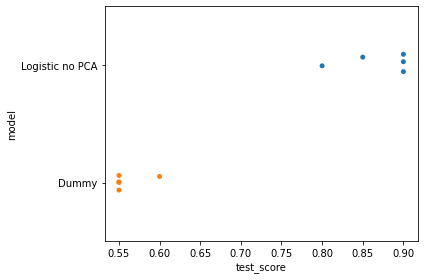

In [ ]:
X, y = load_timeseries_and_site()
models = prepare_pipelines()
all_scores = compute_cv_scores(models, X, y)
print(all_scores.groupby("model").mean())
sns.stripplot(data=all_scores, x="test_score", y="model")
plt.tight_layout()
plt.show()